In [1]:
import os

import matplotlib.pyplot as plt

from utils.evaluations_utils import *
import numpy as np
%matplotlib inline
import matplotlib
import seaborn as sn


start job


<h3> add parameters<h3>

In [18]:
#{tag:plot name}
models = {'davids_ergodic_train':'NMDA','reduction_ergodic_train':'reduction','train_AMPA_gmax1':'AMPA1','train_AMPA_gmax2':'AMPA2','train_AMPA_gmax3':'AMPA3'}
name_order = ['NMDA','reduction','AMPA1','AMPA2','AMPA3']
file_dest = "small_eval_fnum5000_seed6577316389629133448.pkl"
print(models)

{'davids_ergodic_train': 'NMDA', 'reduction_ergodic_train': 'reduction', 'train_AMPA_gmax1': 'AMPA1', 'train_AMPA_gmax2': 'AMPA2', 'train_AMPA_gmax3': 'AMPA3'}


loading model

In [26]:
with open(os.path.join('entropy_data',file_dest),'rb') as f:
    d_dict = pickle.load(f)
print(d_dict.keys())
d = ModelsSEData(data_dict=d_dict)
# d.sample_from_set(d_ratio)
df, m_names = d.get_as_dataframe()
models = {k:v for k,v in models.items()}
# for i in models.keys():
    # df[df['model']==i]['model'] = models[i]
# models = {v:v for v in models.values()}
temp = {k:v for v,k in models.items()}
name_order = [temp[i] if i not in models else i for i in name_order]
df.replace(inplace=True,to_replace=models)


dict_keys(['train_AMPA_gmax3'])


5000it [00:00, 77124.14it/s]


Drop Nones and inf columns

In [20]:

inf_nan_columns = []
for i in df.columns:
    dfinf = df[i]
    if 'ENTROPY' not in i:
        continue
    if dfinf.dtype == object:
        dfinf = np.array(list(dfinf))

    if np.any(np.isinf(dfinf)):
        inf_nan_columns.append(i)
print(inf_nan_columns)
df.drop(inf_nan_columns, axis=1, inplace=True)


['SAMPLE_ENTROPY_s_MSx', 'SAMPLE_ENTROPY_s_CI', 'SAMPLE_ENTROPY_v_MSx', 'SAMPLE_ENTROPY_v_CI']


<h2> Distributions visualization over the CI <h2>

In [23]:
box_plot_data = {}
colors_index={}
c_obj=set()
for i, m in enumerate(name_order):
    colors_index[m]=f'C{i}'
    for c in df.columns:
        if 'CI'in c:
            c_obj.add(c[:-len('_s_CI')])
print(d.data.tags)
for i, m in enumerate(name_order):
    colors_index[m]=f'C{i}'
    for c in df.columns:
        if 'CI'in c:
            if c not in box_plot_data:
                box_plot_data[c]=[]
            print(m)
            box_plot_data[c].append(df[df['model'] == m][c].tolist())
            box_plot_data[c][-1] = np.array(box_plot_data[c][-1])
            print(box_plot_data[c][-1].shape)
for c in c_obj:
    fig, ax = plt.subplots()
    bpa=[]
    keylen = len(box_plot_data)
    c_arr=[]
    i=0
    for k in box_plot_data.keys():
        if not c in k:
            continue
        c_arr.append(k)
        for j,m in enumerate(name_order):
            # print([j+(i*(len(name_order)+1))])
            bp = ax.boxplot(box_plot_data[k][j],positions=[j+(i*(len(name_order)+1))],patch_artist=True, showfliers=False)
            bp['boxes'][0].set_facecolor(colors_index[m])
            bpa.append(bp)
        i+=1

    ax.set_ylabel('Complexity index')
    # ax.set_xticks((np.arange(len(name_order)+1)*len(box_plot_data)))
    a = ax.set_xticks(np.arange(0,(len(name_order)+1)*len(c_arr),len(name_order)+1)+len(name_order)/2-0.5,c_arr)

    # vertical alignment of xtick labels
    # va = [ 0, -.05, 0, -.05, -.05, -.05 ]
    # for t, y in zip( ax.get_xticklabels( ), va ):
    #     t.set_y( y )
    for k,v in colors_index.items():
        ax.plot([],[],color=v,label=k)
    # ax.set_yscale('log')

    # ax.tick_params( axis='x', which='minor', direction='out', length=30 )
    # ax.tick_params( axis='x', which='major', bottom='off', top='off' )
    # ax.set_xticks(np.arange(len(name_order)) + 1, names_for_plots)
    # ax.set_title(f'Sample Entropy Complexity Index (n = {len(box_plot_data[0]) * len(box_plot_data):,})')
    plt.subplots_adjust(bottom=0.4)
    plt.legend()

    fig
    save_large_plot(fig, f"boxplot{c}_{len(d)}.png", tags=d.data_tags)


AttributeError: 'dict' object has no attribute 'tags'

100%|██████████| 2/2 [00:00<00:00,  8.72it/s]


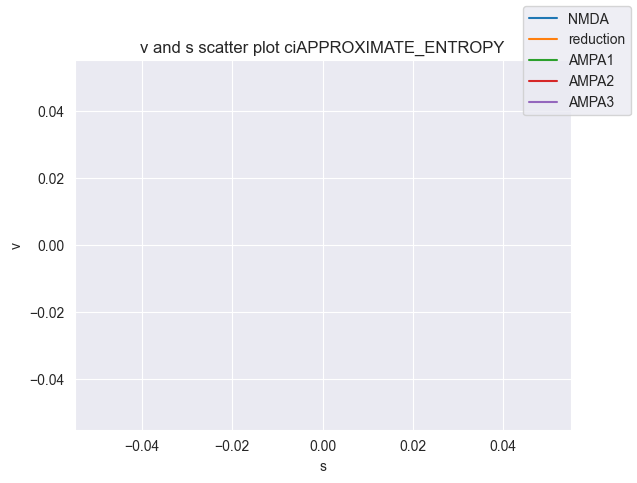

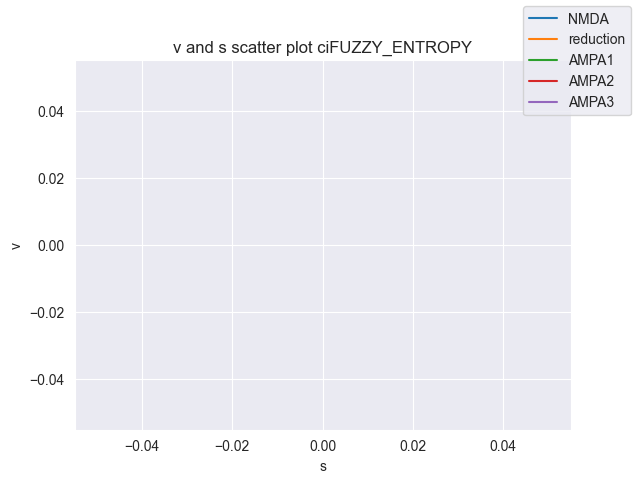

In [6]:
box_plot_data = {}
colors_index={}
c_obj=set()
for i, m in enumerate(name_order):
    colors_index[m]=f'C{i}'
    for c in df.columns:
        if 'CI'in c:
            c_obj.add(c[:-len('_s_CI')])
            if c not in box_plot_data:
                box_plot_data[c]=[]
            box_plot_data[c].append(df[df['model'] == name_order[i]][c].tolist())
            box_plot_data[c][-1] = np.array(box_plot_data[c][-1])

# create data
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents

for i in tqdm(c_obj):
    fig, ax = plt.subplots()
    nbins = 300
    for j,m in enumerate(name_order):
        x,y= box_plot_data[i+'_s_CI'][j],box_plot_data[i+'_v_CI'][j]
        c = ax.scatter(x,y,alpha=0.3,s=0.01)
        ax.plot([],[],color=c.get_facecolor(),label=f'{m}',alpha=1)
    ax.set_ylabel('v')
    ax.set_xlabel('s')
    fig.legend(loc=1)
    ax.set_title(f'v and s scatter plot ci{i}')
    save_large_plot(fig,f'scttervs_{i}_{len(d)}.png',tags=d.data_tags)
    fig


scatter plot of the cis


In [7]:
for c in tqdm(df.columns):
    if not ('ENTROPY' in c and 'CI' in c):
        continue
    df = df.sort_values(['key'])
    datas = []
    ci_data = []
    for i in name_order:
        # datas.append(np.vstack(df[df['model'] == i][c].tolist()))
        ci_data.append(np.vstack(df[df['model'] == i][c].tolist()))
    dist = []
    bins = 200
    # all_data= np.vstack(datas)
    fig, ax = plt.subplots()
    for j, n in enumerate(name_order):
        frequency, bins = np.histogram(ci_data[j], bins=bins)
        frequency = frequency / np.sum(frequency)
        ax.stairs(frequency, bins, fill=True, label=models[n], alpha=0.4)
    fig.legend(loc=1, borderaxespad=3)
    ax.set_title(c.lower().replace('_', ' ').capitalize())
    ax.set_ylabel('P(ci)')
    ax.set_xlabel('ci value')
    save_large_plot(fig,f'dist_1d_{c}_{len(d)}.png',tags=d.data_tags)
    fig

 43%|████▎     | 6/14 [00:00<00:00, 1001.03it/s]


ValueError: need at least one array to concatenate

In [ ]:
box_plot_data = {}
colors_index={}
c_obj=set()
for i, m in enumerate(name_order):
    colors_index[m]=f'C{i}'
    for c in df.columns:
        if 'CI'in c:
            c_obj.add(c[:-len('_s_CI')])
for i, m in enumerate(name_order):
    colors_index[m]=f'C{i}'
    for c in df.columns:
        if 'CI'in c:
            if c not in box_plot_data:
                box_plot_data[c]=[]
            box_plot_data[c].append(df[df['model'] == m][c].tolist())
            box_plot_data[c][-1] = np.array(box_plot_data[c][-1])
for c in tqdm(c_obj):
    # for i,m in enumerate(name_order):
    res = sn.kdeplot(data=df,y = f'{c}_v_CI',x =f'{c}_s_CI', shade=False,hue='model',alpha=0.6)#thresh
    plt.ylabel('v')
    plt.xlabel('s')
    plt.title(c.lower().replace('_',' ').capitalize())
    save_large_plot(plt,f'kde{c}_{len(d)}.png',tags=d.data_tags)
    plt.show()


<h4> norm sorted <h4>

In [ ]:
df = df.sort_values(['key'])
box_plot_data = {}
colors_index={}
c_obj=set()
for i, m in enumerate(name_order):
    colors_index[m]=f'C{i}'
    for c in df.columns:
        if 'CI'in c:
            c_obj.add(c)
for c in c_obj:
    diff_vec = []
    for j in tqdm(name_order):
        # a = df[(df['model'] == j)][c].values
        diff_vec.append(df[(df['model'] == j)][c].values)
    diff_vec = np.array(diff_vec)
    temp_diff_vec = diff_vec.copy()
    a = np.argsort(np.linalg.norm(diff_vec, axis=0))
    fig, ax = plt.subplots()
    mat = diff_vec[:, a]
    im = ax.matshow(mat)
    ax.set_aspect(3000)
    ax.set_xticks([])
    ax.set_xlabel(f'Sorted Trial index (n = {diff_vec.shape[1]:,})')
    ax.set_yticks(range(len(name_order)), name_order)
    ax.set_title(f'Norm Sorted SE Complexity Index {c.lower().replace("_"," ").capitalize()}')
    fig.colorbar(im, location="bottom")
    plt.tight_layout()
    save_large_plot(fig, f'norm_wise_orderd_matrix{c}_{len(d)}.png', d.data_tags)

    fig.show()

<h4> spike count per simulation <h4>

In [ ]:

#spike_count
fig, ax = plt.subplots()
datas = []
for i in name_order:
    datas.append(np.array(df[df['model'] == i]['spikes'].tolist()).sum(axis=1))
    # a=np.mean(np.array(datas[-1]),axis=1)
    # print(i, np.mean(np.array(datas[-1]),axis=1))
names_for_plots_labels = [(mn + f" ($\mu$ = {np.round(np.mean(np.array(datas[i])), 2)})") for i, mn in
                          enumerate(models.values())]
bins = np.arange(30) - 0.5


ax.hist(datas, bins=bins,rwidth=0.75, label=names_for_plots_labels, alpha=1, align='mid')
ax.set_title('Spike Count Per Trial')
# ax.set_yscale('log')
ax.set_xlabel('Number of Spikes in trail')
ax.set_ylabel('Number of Occurrences')
ax.set_xticks(bins[1:(8 * (bins.shape[0] // 8)):2] - 0.5, np.arange(0, (8 * (bins.shape[0] // 8)), 2))
fig.legend(bbox_to_anchor=[0.9, 0.875])
# save_large_plot(fig, 'spike_count.png', name_order)
save_large_plot(fig,f'spike_count_{len(d)}.png',tags=d.data_tags)




distributions

In [ ]:

for i in tqdm(df.columns):
    if not ('ENTROPY' in i and 'CI' in i):
        continue
    print(i)
    datas=[]
    df = df.sort_values(by=['key'])
    prev_index=None
    indexes=None
    for m in name_order:
        prev_index=indexes
        indexes=df[df['model'] == m]['key'].tolist()
        datas.append(np.hstack(df[df['model'] == m][i].tolist()))
        if prev_index is not None:
            assert all(i==j for i,j in zip(prev_index,indexes)),'\n'.join([('' if i==j else str((i,j)))for i,j in zip(prev_index,indexes)])
        # datas.append(np.vstack(df[df['model'] == m][i].tolist()).sum(axis=1))
    for j in combination_sorting(name_order):
        first_index, second_index = j[0],j[1]
        fig, ax = plt.subplots()
        lims = (np.min(np.vstack((datas[first_index], datas[second_index]))),
                np.max(np.vstack((datas[first_index], datas[second_index]))))
        H, xedges, yedges = np.histogram2d(datas[first_index], datas[second_index], range=np.array([lims, lims]),
                                           bins=200)
        # replace zeroes with nan
        H[H == 0] = np.nan
        im = ax.imshow(H.T, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]
                       )
        # , norm=colors.LogNorm())
        ax.plot(lims, lims, color='black')
        slope, intercept, r_value, p_value, std_err = linregress(np.array(datas[first_index]), datas[second_index])
        print(slope)
        reg_intercep = intercept
        reg_coef = slope
        x = lims
        y = [reg_intercep + lims[0] * reg_coef, reg_intercep + lims[1] * reg_coef]
        ax.plot(x, y, color='red')
        fig.colorbar(im)
        ax.set_xlabel(models[name_order[first_index]])
        ax.set_ylabel(models[name_order[second_index]])
        ax.set_ylim(lims)
        ax.set_xlim(lims)
        ax.set_title(
            f"{models[name_order[first_index]]} and {models[name_order[second_index]]} trials {i} \nn = {len(datas[second_index]) * 2:,} ,$R^2$ = {np.round(r_value ** 2, 4)}")
        fig
        save_large_plot(fig, f"pairwise_2dhist_{i}_{models[name_order[first_index]]}_{models[name_order[second_index]]}_{len(d)}.png", tags=d.data_tags)


In [ ]:

# %% print temporal mean and error
relevant_cols_msx=[]
relevant_cols_ci=[]
for i in df.columns:
    if 'MSx'in i:
        relevant_cols_msx.append(i)
    elif 'CI' in i:
        relevant_cols_ci.append(i)
df = df.sort_values(['key'])
datas = {}
ci_data={}
threshold=None
# from scipy.stats import sem

for m in tqdm(name_order):
    datas[m]=[]
    ci_data[m]=[]
    for c in relevant_cols_msx:
        datas[m].append(np.vstack(df[df['model'] == m][c].tolist()))
    for c in relevant_cols_ci:
        ci_data[m].append(np.vstack(df[df['model'] == m][c].tolist()))

# ci_data = np.hstack(ci_data)
# indexes=np.arange(ci_data[0].shape[0])
for i,c in enumerate(relevant_cols_msx):
    fig, ax = plt.subplots()
    for m in tqdm(name_order):
        print(c)
        if threshold is not None:
            mean = np.mean(datas[m][i], axis=0)
            std =  np.std(datas[m][i], axis=0)
        else:
            mean = np.mean(datas[m][i], axis=0)
            std = np.std(datas[m][i], axis=0)
        ax.plot(np.arange(datas[m][i].shape[1]), mean, label=f'{models[m]}')
        ax.fill_between(np.arange(datas[m][i].shape[1]), mean - std, mean + std, alpha=0.3)
    ax.legend(loc='upper left')
    # if threshold is not None:
    # ax.set_title(
    # f'Average SE Across Different Time Scales (n = {len(datas[0]) * len(datas):,}) \nCi value {"greater" if direction > 0 else "lower"} than {threshold_value:0.4}')
    # else:
    #     ax.set_title(f'Average SE Across Different Time Scales (n = {len(datas[0]) * len(datas):,})')
    ax.set_xlabel('Time Scales')
    ax.set_ylabel('SE value')
    ax.set_title(c.lower().replace('_',' ').capitalize())
    save_large_plot(fig,f'temporal_msx_{c}_{len(d)}.png',tags=d.data_tags)

    fig